# ДЗ2 - алгоритм актор-критик
Крайний срок сдачи - 24.03.2019 23:59.

***
Задача будет заключаться в том, чтобы провести эксперименты с алгоритмом актор-критик, который мы подробно разбирали на семинарах. Ваше решение в виде Jupyter тетрадки *с комментариями* нужно загрузить по [ссылке](https://www.dropbox.com/request/nBSHbnUTG9sLnEexYSW2) с шаблоном имени "Фамилия>\_ИАД<номер группы>.ipynb", например Панов_ИАД1.ipynb. Указывать ту группу, которую вы посещаете на семинарах.

## Требования:
### 1. __TensorFlow:__
Инструкции-напоминания по установке здесь - https://www.tensorflow.org/get_started/os_setup. GPU не будет требоваться для выполнения ДЗ.
### 2. __OpenAI Gym:__  
Напоминание-инструкции по OpenAI Gym - https://gym.openai.com/docs. Используйте версию 0.10.5.
### 3. __TensorFlow-probabilities:__<br>
Инструкции по установке - https://www.tensorflow.org/probability/install. Возможно, вам понадобится обновить TensorFlow и numpy. Еще нам файл logz.py ля полезных функций ведения лога процесса обучения.
***

Импортируем все необходимое и пишем вспомогательные функции:

In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)

import tensorflow_probability as tfp
import gym
print(gym.__version__)

import logz
import os
import time
import inspect
#import tf_util
from multiprocessing import Process

import matplotlib.pyplot as plt
from IPython.display import clear_output

def pathlength(path):
    return len(path["reward"])

def setup_logger(logdir, locals_):
    # Configure output directory for logging
    logz.configure_output_dir(logdir)
    # Log experimental parameters
    args = inspect.getargspec(train_PG)[0]
    params = {k: locals_[k] if k in locals_ else None for k in args}
    logz.save_params(params)
    
fig=None
x=[]
y=[]

def plot(t,mean_r):
    if t==0:
        fig=plt.figure()
    x.append(t)
    y.append(mean_r)
    clear_output(wait=True)
    plt.plot(x,y,label='mean_reward')
    plt.xlabel("Number of iterations")
    plt.ylabel("Reward")
    plt.legend()
    plt.show()

1.13.1

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

0.10.5


***
## Напоминаем необходимые формулы

Напоминаем алгоритм актор-критика:

<img src="https://raw.githubusercontent.com/Alonso94/homework/master/hw3/ac.png"/>

Вычслять градиент целевой функции для определения градиент стратегии мы будем по следующей формуле: 

$$\nabla_\theta J(\theta)\approx\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{T} \nabla_\theta\log\pi_\theta(a_{it},s_{it}) A^\pi(s_t,a_t).$$

Здесь мы оцениваем функцию полезности действия через функцию преимущества $A$, которую для уменьшения дисперсии решения будем представлять в виде разницы оценки критика  и базовой функции $B(s)=V_v^\pi(s)$:

$$A^\pi(s_t,a_t)\approx r(a_t,s_t)+\gamma V_v^\pi(s_{t+1})-V_v^\pi(s_{it})$$

Критик, который оценивает функцию преимущества минимизует среднеквадратичную ошибку для TD-показателя $y_t=r(a_t,s_t)+\gamma V^\pi(s_{t+1})$:

$$\min_v \sum_{i,t}(V_v^\pi(s_{it})-y_{it})^2.$$

Для того, чтобы ускорить работу мы будем повторять слеюущие два шага:

1. Обновлять показатель со старым значеним функции полезности.
2. Делаем несколько градиентных шагов для обновления функции полезности.

Т.е. мы обучение критика идет интерстивно: обновляем критерий и затем обновляем саму функцию.

### Задание 1. Создаем аппроксиматор (2 балла).

Нам нужно создать простой аппроксиматор в виде нескольких слоев (__n_layers__) полносвязных нейронных сетей (__tf.layers.dense__). Большиснтвоа параметров передается вам в качестве параметров.

In [2]:
def build_mlp(input_placeholder, output_size, scope, n_layers, size, activation=tf.tanh, output_activation=None):
    """
        Builds a feedforward neural network
        
        arguments:
            input_placeholder: placeholder variable for the state (batch_size, input_size)
            output_size: size of the output layer
            scope: variable scope of the network
            n_layers: number of hidden layers
            size: dimension of the hidden layer
            activation: activation of the hidden layers
            output_activation: activation of the ouput layers
        returns:
            output placeholder of the network (the result of a forward pass) 
        Hint: use tf.layers.dense    
    """
    with tf.variable_scope(scope):
        output_placeholder = input_placeholder
        for i in range(n_layers):
            output_placeholder = tf.layers.dense(output_placeholder, size, activation = activation)
        output_placeholder = tf.layers.dense(output_placeholder, output_size, activation = output_activation)    

    return output_placeholder

Далее мы будем реализовывать основной класс Agent. Вначале определим его конструктор, параметры которого будем брать из словаря __computation_graph_args__. Параметры __computation_graph_args__ - вспомогательные.

In [3]:
class Agent(object):
    def __init__(self, computation_graph_args, sample_trajectory_args, estimate_advantage_args):
        super(Agent, self).__init__()
        self.ob_dim = computation_graph_args['ob_dim']
        self.ac_dim = computation_graph_args['ac_dim']
        self.discrete = computation_graph_args['discrete']
        self.size = computation_graph_args['size']
        self.n_layers = computation_graph_args['n_layers']
        self.learning_rate = computation_graph_args['learning_rate']
        self.num_target_updates = computation_graph_args['num_target_updates']
        self.num_grad_steps_per_target_update = computation_graph_args['num_grad_steps_per_target_update']

        self.animate = sample_trajectory_args['animate']
        self.max_path_length = sample_trajectory_args['max_path_length']
        self.min_timesteps_per_batch = sample_trajectory_args['min_timesteps_per_batch']

        self.gamma = estimate_advantage_args['gamma']
        self.normalize_advantages = estimate_advantage_args['normalize_advantages']

    def init_tf_sess(self):
        tf_config = tf.ConfigProto(inter_op_parallelism_threads=1, intra_op_parallelism_threads=1)
        tf_config.gpu_options.allow_growth = True # may need if using GPU
        self.sess = tf.Session(config=tf_config)
        self.sess.__enter__() # equivalent to `with self.sess:`
        tf.global_variables_initializer().run() #pylint: disable=E1101
        
    def reset_tf_sess(self):
        self.sess = tf.reset_default_graph()
        
    def define_placeholders(self):
        """
            Placeholders for batch batch observations / actions / advantages in actor critic
            loss function.
            See Agent.build_computation_graph for notation

            returns:
                sy_ob_no: placeholder for observations
                sy_ac_na: placeholder for actions
                sy_adv_n: placeholder for advantages
        """
        sy_ob_no = tf.placeholder(shape=[None, self.ob_dim], name="ob", dtype=tf.float32)
        if self.discrete:
            sy_ac_na = tf.placeholder(shape=[None], name="ac", dtype=tf.int32) 
        else:
            sy_ac_na = tf.placeholder(shape=[None, self.ac_dim], name="ac", dtype=tf.float32) 
        
        sy_adv_n = tf.placeholder(shape=[None],name="advantage",dtype=tf.float32)
        return sy_ob_no, sy_ac_na, sy_adv_n

***
### Задание 2. Реализуем алгоритм работы актора

Во-первых нам нужно дописать код для определения действия по текущему наблюдению (__sy_ob_no__). Эта операция будет различаться для непрерывных и дискретных окружений.

In [4]:
def policy_forward_pass(self, sy_ob_no):
    """ Constructs the symbolic operation for the policy network outputs,
        which are the parameters of the policy distribution p(a|s)
        arguments:
            sy_ob_no: (batch_size, self.ob_dim)
        returns:
            the parameters of the policy.
            if discrete, the parameters are the logits of a categorical distribution
                over the actions
                sy_logits_na: (batch_size, self.ac_dim)
            if continuous, the parameters are a tuple (mean, log_std) of a Gaussian
                distribution over actions. log_std should just be a trainable
                variable, not a network output.
                sy_mean: (batch_size, self.ac_dim)
                sy_logstd: (self.ac_dim,)
        Hint: use the 'build_mlp' function to output the logits (in the discrete case)
            and the mean (in the continuous case).
            Pass in self.n_layers for the 'n_layers' argument, and
            pass in self.size for the 'size' argument.
    """
    
    scope="nn_policy"
    if self.discrete:
        sy_logits_na = build_mlp(sy_ob_no,self.ac_dim,scope,self.n_layers,self.size, activation=tf.nn.relu)
        return sy_logits_na
    else:
        sy_mean = build_mlp(sy_ob_no,self.ac_dim,scope,self.n_layers,self.size,activation=tf.nn.relu)
        sy_logstd = tf.Variable(np.zeros(self.ac_dim),name="sy_logstd")
        return (sy_mean, sy_logstd)
    
Agent.policy_forward_pass = policy_forward_pass

Далее мы выбираем нужное действие из распределения, которое задается нам стратегией. Для дискретного и непрерывного случая используем разные методы (__tf.squeeze__ и __tf.random_normal__).

In [5]:
def sample_action(self, policy_parameters):
    """ Constructs a symbolic operation for stochastically sampling from the policy
        distribution
        arguments:
            policy_parameters
                if discrete: logits of a categorical distribution over actions 
                    sy_logits_na: (batch_size, self.ac_dim)
                if continuous: (mean, log_std) of a Gaussian distribution over actions
                    sy_mean: (batch_size, self.ac_dim)
                    sy_logstd: (self.ac_dim,)
        returns:
            sy_sampled_ac: 
                if discrete: (batch_size,)
                if continuous: (batch_size, self.ac_dim)
        Hint: for the continuous case, use the reparameterization trick:
             The output from a Gaussian distribution with mean 'mu' and std 'sigma' is

                  mu + sigma * z,         z ~ N(0, I)

             This reduces the problem to just sampling z. (Hint: use tf.random_normal!)
    """
    if self.discrete:
        sy_logits_na = policy_parameters
        # use tf.squeeze (Removes dimensions of size 1 from the shape of a tensor.)
        sy_sampled_ac = tf.squeeze(tf.multinomial(sy_logits_na, 1), axis=1)
    else:
        sy_mean, sy_logstd = policy_parameters
        exp=tf.cast(tf.exp(sy_logstd), dtype=tf.float32)
        sy_sampled_ac = sy_mean + exp * tf.random_normal(shape=tf.shape(sy_mean))
    return sy_sampled_ac

Agent.sample_action = sample_action

Далее мы вычисляем логарифм вероятности действия для использования в целевой функции.

In [6]:
def get_log_prob(self, policy_parameters, sy_ac_na):
    """ Constructs a symbolic operation for computing the log probability of a set of actions
        that were actually taken according to the policy
        arguments:
            policy_parameters
                if discrete: logits of a categorical distribution over actions 
                    sy_logits_na: (batch_size, self.ac_dim)
                if continuous: (mean, log_std) of a Gaussian distribution over actions
                    sy_mean: (batch_size, self.ac_dim)
                    sy_logstd: (self.ac_dim,)
            sy_ac_na: 
                if discrete: (batch_size,)
                if continuous: (batch_size, self.ac_dim)
        returns:
            sy_logprob_n: (batch_size)
        Hint:
            For the discrete case, use the log probability under a categorical distribution.
            For the continuous case, use the log probability under a multivariate gaussian.
    """
    if self.discrete:
        sy_logits_na = policy_parameters
        # use tf.nn.sparse_softmax_cross_entropy_with_logits
        sy_logprob_n = - tf.nn.sparse_softmax_cross_entropy_with_logits(labels=sy_ac_na,logits=sy_logits_na)
    else:
        sy_mean, sy_logstd = policy_parameters
        # multivariate gaussian (tf.distributions.Normal)
        exp=tf.cast(tf.exp(sy_logstd),dtype=tf.float32)
        probabilities = tf.distributions.Normal(sy_mean, exp).prob(sy_ac_na)
        sy_logprob_n = tf.log(tf.reduce_prod(probabilities, axis=1))
    return sy_logprob_n

Agent.get_log_prob = get_log_prob

Наконец, записываем код обновления параметров актора в сессии. Здесь __actor_update_op__ - оптимизатор, который определим позже. 

In [7]:
def update_actor(self, ob_no, ac_na, adv_n):
    """ 
        Update the parameters of the policy.

        arguments:
            ob_no: shape: (sum_of_path_lengths, ob_dim)
            ac_na: shape: (sum_of_path_lengths).
            adv_n: shape: (sum_of_path_lengths). A single vector for the estimated
                advantages whose length is the sum of the lengths of the paths

        returns:
            nothing

    """
    self.sess.run(self.actor_update_op,feed_dict={self.sy_ob_no: ob_no, self.sy_ac_na: ac_na, self.sy_adv_n: adv_n})
    
Agent.update_actor = update_actor

***
### Задание 3. Пишем код для критика (4 балла).

Начнем с оценки функции преимущества (см. формулы в начале тетрадки).

In [8]:
def estimate_advantage(self, ob_no, next_ob_no, re_n, terminal_n):
    """
        Estimates the advantage function value for each timestep.

        let sum_of_path_lengths be the sum of the lengths of the paths sampled from 
            Agent.sample_trajectories

        arguments:
            ob_no: shape: (sum_of_path_lengths, ob_dim)
            next_ob_no: shape: (sum_of_path_lengths, ob_dim). The observation after taking one step forward
            re_n: length: sum_of_path_lengths. Each element in re_n is a scalar containing
                the reward for each timestep
            terminal_n: length: sum_of_path_lengths. Each element in terminal_n is either 1 if the episode ended
                at that timestep of 0 if the episode did not end

        returns:
            adv_n: shape: (sum_of_path_lengths). A single vector for the estimated 
                advantages whose length is the sum of the lengths of the paths
    """
    # First, estimate the Q value as Q(s, a) = r(s, a) + gamma*V(s')
    # To get the advantage, subtract the V(s) to get A(s, a) = Q(s, a) - V(s)
    # This requires calling the critic twice --- to obtain V(s') when calculating Q(s, a),
    # and V(s) when subtracting the baseline
    # Note: don't forget to use terminal_n to cut off the V(s') term when computing Q(s, a)
    # otherwise the values will grow without bound.

    adv_n = []
    # Ваш код здесь
    # Считаем значение полезност следующего состояния s' через критика
    v_s_tp1_n = self.sess.run(self.critic_prediction, feed_dict = {self.sy_ob_no: next_ob_no})
    # Считаем значение полезност текущего состояния s через критика
    v_s_t_n = self.sess.run(self.critic_prediction, feed_dict = {self.sy_ob_no: ob_no})
    # Считаем значение Q(s, a) = r(s, a) + gamma*V(s')
    q_n = re_n + self.gamma * v_s_tp1_n
    # Считаем A(s, a) = Q(s, a) - V(s)
    adv_n = q_n - v_s_t_n        

    if self.normalize_advantages:
        # Ваш код здесь
        # Вчитаем среднее и делим на дисперсию
        adv_n = (adv_n - np.mean(adv_n))/np.std(avdv_n)
    return adv_n

Agent.estimate_advantage = estimate_advantage

Теперь неободимо записать то, как мы обновляем параметры критика в сессии.

In [9]:
def update_critic(self, ob_no, next_ob_no, re_n, terminal_n):
    """
        Update the parameters of the critic.

        let sum_of_path_lengths be the sum of the lengths of the paths sampled from
            Agent.sample_trajectories
        let num_paths be the number of paths sampled from Agent.sample_trajectories

        arguments:
            ob_no: shape: (sum_of_path_lengths, ob_dim)
            next_ob_no: shape: (sum_of_path_lengths, ob_dim). The observation after taking one step forward
            re_n: length: sum_of_path_lengths. Each element in re_n is a scalar containing
                the reward for each timestep
            terminal_n: length: sum_of_path_lengths. Each element in terminal_n is either 1 if the episode ended
                at that timestep of 0 if the episode did not end

        returns:
            nothing
    """
    # Use a bootstrapped target values to update the critic
    # Compute the target values r(s, a) + gamma*V(s') by calling the critic to compute V(s')
    # In total, take n=self.num_grad_steps_per_target_update*self.num_target_updates gradient update steps
    # Every self.num_grad_steps_per_target_update steps, recompute the target values
    # by evaluating V(s') on the updated critic
    # Note: don't forget to use terminal_n to cut off the V(s') term when computing the target
    # otherwise the values will grow without bound.

    for i in range(self.num_target_updates):
        target_n = []
        # Ваш код здесь
        # Считаем значение полезност следующего состояния s' через критика
        v_s_tp1_n = self.sess.run(self.critic_prediction, feed_dict = {self.sy_ob_no: next_ob_no})
        # Считаем значение показателя временных различий r(s, a) + gamma*V(s') если это не терминальное состояние
        target_n = re_n + self.gamma * v_s_tp1_n * (1 - terminal_n)

        for j in range(self.num_grad_steps_per_target_update):
            self.sess.run(self.critic_update_op, feed_dict={self.sy_target_n: target_n,self.sy_ob_no: ob_no})
            
Agent.update_critic = update_critic

***
### Задание 4. Собираем все вместе.

Теперь нам осталось собрать все предыдущие методы в один граф вычислений.

In [10]:
def build_computation_graph(self):
    """
        Notes on notation:

        Symbolic variables have the prefix sy_, to distinguish them from the numerical values
        that are computed later in the function

        Prefixes and suffixes:
        ob - observation 
        ac - action
        _no - this tensor should have shape (batch self.size /n/, observation dim)
        _na - this tensor should have shape (batch self.size /n/, action dim)
        _n  - this tensor should have shape (batch self.size /n/)

        Note: batch self.size /n/ is defined at runtime, and until then, the shape for that axis
        is None

        ----------------------------------------------------------------------------------
        loss: a function of self.sy_logprob_n and self.sy_adv_n that we will differentiate
            to get the policy gradient.
    """
    #self.sess = tf.reset_default_graph()
    self.sy_ob_no, self.sy_ac_na, self.sy_adv_n = self.define_placeholders()

    # The policy takes in an observation and produces a distribution over the action space
    self.policy_parameters = self.policy_forward_pass(self.sy_ob_no)

    # We can sample actions from this action distribution.
    # This will be called in Agent.sample_trajectory() where we generate a rollout.
    self.sy_sampled_ac = self.sample_action(self.policy_parameters)

    # We can also compute the logprob of the actions that were actually taken by the policy
    # This is used in the loss function.
    self.sy_logprob_n = self.get_log_prob(self.policy_parameters, self.sy_ac_na)

    actor_loss = tf.reduce_sum(-self.sy_logprob_n * self.sy_adv_n)
    self.actor_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(actor_loss)

    # define the critic
    self.critic_prediction = tf.squeeze(build_mlp(
                            self.sy_ob_no,
                            1,
                            "nn_critic",
                            n_layers=self.n_layers,
                            size=self.size))
    self.sy_target_n = tf.placeholder(shape=[None], name="critic_target", dtype=tf.float32)
    self.critic_loss = tf.losses.mean_squared_error(self.sy_target_n, self.critic_prediction)
    self.critic_update_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.critic_loss)

Agent.build_computation_graph = build_computation_graph

Добавим к агенту еще пару методов работы со статистикой.

In [11]:
def sample_trajectories(self, itr, env):
    # Collect paths until we have enough timesteps
    timesteps_this_batch = 0
    paths = []
    while True:
        animate_this_episode=(len(paths)==0 and (itr % 10 == 0) and self.animate)
        path = self.sample_trajectory(env, animate_this_episode)
        paths.append(path)
        timesteps_this_batch += pathlength(path)
        if timesteps_this_batch > self.min_timesteps_per_batch:
            break
    return paths, timesteps_this_batch

def sample_trajectory(self, env, animate_this_episode):
    ob = env.reset()
    obs, acs, rewards, next_obs, terminals = [], [], [], [], []
    steps = 0
    while True:
        if animate_this_episode:
            #env.render()
            time.sleep(0.1)
        obs.append(ob)
        ac = self.sess.run(self.sy_sampled_ac, feed_dict={self.sy_ob_no: ob[None, :]}) # YOUR HW2 CODE HERE
        ac = ac[0]
        acs.append(ac)
        ob, rew, done, _ = env.step(ac)
        # add the observation after taking a step to next_obs
        next_obs.append(ob)
        rewards.append(rew)
        steps += 1
        # If the episode ended, the corresponding terminal value is 1
        # otherwise, it is 0
        if done or steps > self.max_path_length:
            terminals.append(1)
            break
        else:
            terminals.append(0)
    path = {"observation" : np.array(obs, dtype=np.float32), 
            "reward" : np.array(rewards, dtype=np.float32), 
            "action" : np.array(acs, dtype=np.float32),
            "next_observation": np.array(next_obs, dtype=np.float32),
            "terminal": np.array(terminals, dtype=np.float32)}
    return path

Agent.sample_trajectories = sample_trajectories
Agent.sample_trajectory = sample_trajectory

***
### Задание 5. Проводим экспермиенты (4 баллов).

Ниже записан код, в котором мы проводим эксперименты с построенным агентом. Вначале мы инициализируем окружение (Set Up Env), затем создаем агента (Initialize Agent) и запускаем его в среду в цикле (Training Loop).

In [12]:
def train_AC(
        exp_name,
        env_name,
        n_iter=100, 
        gamma=1, 
        min_timesteps_per_batch=1000, 
        max_path_length=None,
        learning_rate=5e-3,
        num_target_updates=10,
        num_grad_steps_per_target_update=10,
        animate=True, 
        normalize_advantages=True,
        seed=1,
        n_layers=2,
        size=64):

    start = time.time()

    #========================================================================================#
    # Set Up Env
    #========================================================================================#

    # Make the gym environment
    env = gym.make(env_name)
    # Set random seeds
    tf.set_random_seed(seed)
    np.random.seed(seed)
    env.seed(seed)

    # Maximum length for episodes
    max_path_length = max_path_length or env.spec.max_episode_steps

    # Is this env continuous, or self.discrete?
    discrete = isinstance(env.action_space, gym.spaces.Discrete)

    # Observation and action sizes
    ob_dim = env.observation_space.shape[0]
    ac_dim = env.action_space.n if discrete else env.action_space.shape[0]

    #========================================================================================#
    # Initialize Agent
    #========================================================================================#

    computation_graph_args = {
        'n_layers': n_layers,
        'ob_dim': ob_dim,
        'ac_dim': ac_dim,
        'discrete': discrete,
        'size': size,
        'learning_rate': learning_rate,
        'num_target_updates': num_target_updates,
        'num_grad_steps_per_target_update': num_grad_steps_per_target_update,
        }

    sample_trajectory_args = {
        'animate': animate,
        'max_path_length': max_path_length,
        'min_timesteps_per_batch': min_timesteps_per_batch,
        }

    estimate_advantage_args = {
        'gamma': gamma,
        'normalize_advantages': normalize_advantages,
        }
    
    agent = Agent(computation_graph_args, sample_trajectory_args, estimate_advantage_args) #estimate_return_args
    # build computation graph
    agent.build_computation_graph()
    # tensorflow: config, session, variable initialization
    agent.init_tf_sess()
    #========================================================================================#
    # Training Loop
    #========================================================================================#
    total_timesteps = 0
    for itr in range(n_iter):
        print("********** Iteration %i ************"%itr)
        paths, timesteps_this_batch = agent.sample_trajectories(itr, env)
        total_timesteps += timesteps_this_batch

        # Build arrays for observation, action for the policy gradient update by concatenating 
        # across paths
        ob_no = np.concatenate([path["observation"] for path in paths])
        ac_na = np.concatenate([path["action"] for path in paths])
        re_n = np.concatenate([path["reward"] for path in paths])
        next_ob_no = np.concatenate([path["next_observation"] for path in paths])
        terminal_n = np.concatenate([path["terminal"] for path in paths])

        # Call tensorflow operations to:
        # (1) update the critic, by calling agent.update_critic
        # (2) use the updated critic to compute the advantage by, calling agent.estimate_advantage
        # (3) use the estimated advantage values to update the actor, by calling agent.update_actor
        # YOUR CODE HERE
        agent.update_critic(ob_no, next_ob_no, re_n, terminal_n)
        adv_n = agent.estimate_advantage(ob_no, next_ob_no, re_n, terminal_n)
        agent.update_actor(ob_no, ac_na, adv_n)
        
        # Log diagnostics
        returns = [path["reward"].sum() for path in paths]
        ep_lengths = [pathlength(path) for path in paths]
        plot(itr,np.mean(returns)) 
        print("Time", time.time() - start)
        print("Iteration", itr)
        print("AverageReturn", np.mean(returns))
        print("StdReturn", np.std(returns))
        print("MaxReturn", np.max(returns))
        print("MinReturn", np.min(returns))
        print("EpLenMean", np.mean(ep_lengths))
        print("EpLenStd", np.std(ep_lengths))
        print("TimestepsThisBatch", timesteps_this_batch)
        print("TimestepsSoFar", total_timesteps)
    agent.sess.__exit__(None,None,None)
    tf.reset_default_graph()
    #agent.reset_tf_sess()
    #tf.keras.backend.clear_session()

Проведите эксперименты с несколькими окружениями и разными параметрами: __CartPole-v0__ (num_target_updates=[1,1,100], num_grad_steps_per_target_update=[1,10,100], max_path_length=3000). Выберете лучшее сочетание для num_target_updates и num_grad_steps_per_target_update и с этми параметрами проверьте __InvertedPendulum-v2__ (gamma=0.9, learning_rate=0.01, min_timesteps_per_batch=5000, size=64, max_path_length=-1.), __HalfCheetah-v2__ (gamma=0.95, learning_rate=0.02, min_timesteps_per_batch=30000, size=32, max_path_length=-1.). Для каждого окружения опишите особенности окружения, постройте графики качества работы агента, прокомментируйте результаты. 

In [13]:
nums = [1, 10, 100]
l = []
for i in nums:
    for j in nums:
        print(i,j)
        l.append(i)
        l.append(j)     

1 1
1 10
1 100
10 1
10 10
10 100
100 1
100 10
100 100


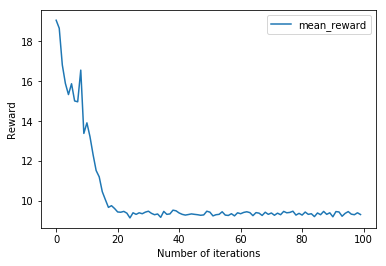

Time 37.69783115386963
Iteration 99
AverageReturn 9.324074
StdReturn 0.77970445
MaxReturn 11.0
MinReturn 8.0
EpLenMean 9.324074074074074
EpLenStd 0.7797044039095805
TimestepsThisBatch 1007
TimestepsSoFar 100609


In [14]:
#1 1
train_AC(
        exp_name="CartPole-v0",
        env_name="CartPole-v0",
        n_iter=100,
        gamma=1,
        min_timesteps_per_batch=1000,
        max_path_length=3000,
        learning_rate=5e-3,
        num_target_updates=l[0],
        num_grad_steps_per_target_update=l[1],
        animate=True,
        normalize_advantages=False,
        seed=1,
        n_layers=2,
        size=64)

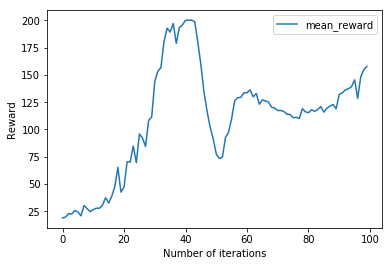

Time 130.80990028381348
Iteration 99
AverageReturn 157.71428
StdReturn 5.9453287
MaxReturn 170.0
MinReturn 150.0
EpLenMean 157.71428571428572
EpLenStd 5.94532915619566
TimestepsThisBatch 1104
TimestepsSoFar 106366


In [14]:
#1 10
train_AC(
        exp_name="CartPole-v0",
        env_name="CartPole-v0",
        n_iter=100,
        gamma=1,
        min_timesteps_per_batch=1000,
        max_path_length=3000,
        learning_rate=5e-3,
        num_target_updates=l[2],
        num_grad_steps_per_target_update=l[3],
        animate=True,
        normalize_advantages=False,
        seed=1,
        n_layers=2,
        size=64)

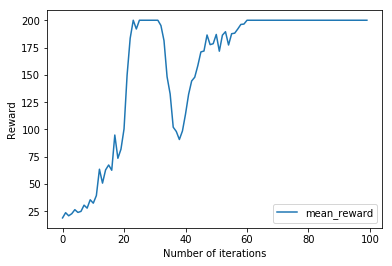

Time 187.34233021736145
Iteration 99
AverageReturn 200.0
StdReturn 0.0
MaxReturn 200.0
MinReturn 200.0
EpLenMean 200.0
EpLenStd 0.0
TimestepsThisBatch 1200
TimestepsSoFar 113052


In [14]:
#1 100
train_AC(
        exp_name="CartPole-v0",
        env_name="CartPole-v0",
        n_iter=100,
        gamma=1,
        min_timesteps_per_batch=1000,
        max_path_length=3000,
        learning_rate=5e-3,
        num_target_updates=l[4],
        num_grad_steps_per_target_update=l[5],
        animate=True,
        normalize_advantages=False,
        seed=1,
        n_layers=2,
        size=64)

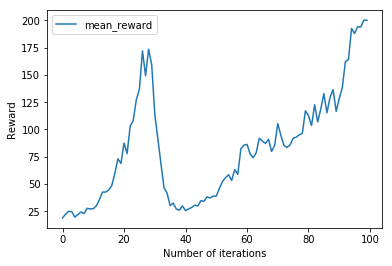

Time 100.61157727241516
Iteration 99
AverageReturn 200.0
StdReturn 0.0
MaxReturn 200.0
MinReturn 200.0
EpLenMean 200.0
EpLenStd 0.0
TimestepsThisBatch 1200
TimestepsSoFar 104811


In [14]:
#10 1
train_AC(
        exp_name="CartPole-v0",
        env_name="CartPole-v0",
        n_iter=100,
        gamma=1,
        min_timesteps_per_batch=1000,
        max_path_length=3000,
        learning_rate=5e-3,
        num_target_updates=l[6],
        num_grad_steps_per_target_update=l[7],
        animate=True,
        normalize_advantages=False,
        seed=1,
        n_layers=2,
        size=64)

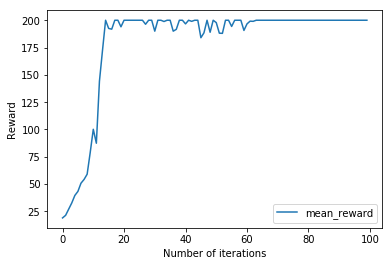

Time 225.8484091758728
Iteration 99
AverageReturn 200.0
StdReturn 0.0
MaxReturn 200.0
MinReturn 200.0
EpLenMean 200.0
EpLenStd 0.0
TimestepsThisBatch 1200
TimestepsSoFar 116826


In [14]:
#10 10
train_AC(
        exp_name="CartPole-v0",
        env_name="CartPole-v0",
        n_iter=100,
        gamma=1,
        min_timesteps_per_batch=1000,
        max_path_length=3000,
        learning_rate=5e-3,
        num_target_updates=l[8],
        num_grad_steps_per_target_update=l[9],
        animate=True,
        normalize_advantages=False,
        seed=1,
        n_layers=2,
        size=64)

10 100 наилучшее сочетание т.к наиболее стабильное качество после ~25 итерации, при этом сочетании добивается цели чаще, 
чем в остальных случаях, но с параметрами 10 10 результат достигается быстрее

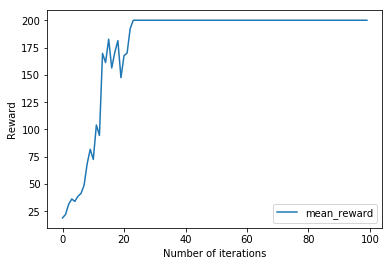

Time 360.9624261856079
Iteration 99
AverageReturn 200.0
StdReturn 0.0
MaxReturn 200.0
MinReturn 200.0
EpLenMean 200.0
EpLenStd 0.0
TimestepsThisBatch 1200
TimestepsSoFar 116847


In [14]:
#10 100
train_AC(
        exp_name="CartPole-v0",
        env_name="CartPole-v0",
        n_iter=100,
        gamma=1,
        min_timesteps_per_batch=1000,
        max_path_length=3000,
        learning_rate=5e-3,
        num_target_updates=l[10],
        num_grad_steps_per_target_update=l[11],
        animate=True,
        normalize_advantages=False,
        seed=1,
        n_layers=2,
        size=64)

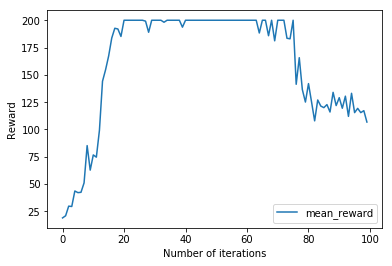

Time 198.81418204307556
Iteration 99
AverageReturn 106.8
StdReturn 8.0349245
MaxReturn 119.0
MinReturn 94.0
EpLenMean 106.8
EpLenStd 8.034923770640265
TimestepsThisBatch 1068
TimestepsSoFar 113557


In [14]:
#100 1
train_AC(
        exp_name="CartPole-v0",
        env_name="CartPole-v0",
        n_iter=100,
        gamma=1,
        min_timesteps_per_batch=1000,
        max_path_length=3000,
        learning_rate=5e-3,
        num_target_updates=l[12],
        num_grad_steps_per_target_update=l[13],
        animate=True,
        normalize_advantages=False,
        seed=1,
        n_layers=2,
        size=64)

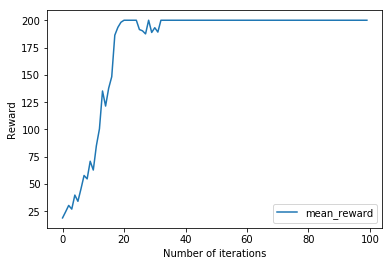

Time 371.79001474380493
Iteration 99
AverageReturn 200.0
StdReturn 0.0
MaxReturn 200.0
MinReturn 200.0
EpLenMean 200.0
EpLenStd 0.0
TimestepsThisBatch 1200
TimestepsSoFar 116953


In [14]:
#100 10
train_AC(
        exp_name="CartPole-v0",
        env_name="CartPole-v0",
        n_iter=100,
        gamma=1,
        min_timesteps_per_batch=1000,
        max_path_length=3000,
        learning_rate=5e-3,
        num_target_updates=l[14],
        num_grad_steps_per_target_update=l[15],
        animate=True,
        normalize_advantages=False,
        seed=1,
        n_layers=2,
        size=64)

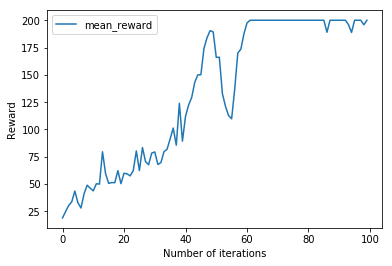

Time 1767.6267266273499
Iteration 99
AverageReturn 200.0
StdReturn 0.0
MaxReturn 200.0
MinReturn 200.0
EpLenMean 200.0
EpLenStd 0.0
TimestepsThisBatch 1200
TimestepsSoFar 111345


In [14]:
#100 100
train_AC(
        exp_name="CartPole-v0",
        env_name="CartPole-v0",
        n_iter=100,
        gamma=1,
        min_timesteps_per_batch=1000,
        max_path_length=3000,
        learning_rate=5e-3,
        num_target_updates=l[16],
        num_grad_steps_per_target_update=l[17],
        animate=True,
        normalize_advantages=False,
        seed=1,
        n_layers=2,
        size=64)

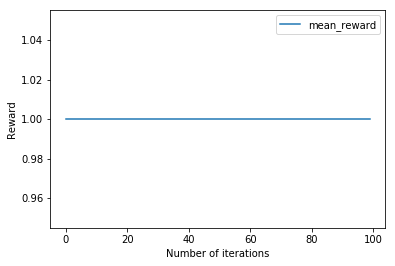

Time 997.7493374347687
Iteration 99
AverageReturn 1.0
StdReturn 0.0
MaxReturn 1.0
MinReturn 1.0
EpLenMean 1.0
EpLenStd 0.0
TimestepsThisBatch 5001
TimestepsSoFar 500100


In [13]:
train_AC(
        exp_name="InvertedPendulum-v2",
        env_name="InvertedPendulum-v2",
        n_iter=100,
        gamma=0.9,
        min_timesteps_per_batch=5000,
        max_path_length=-1,
        learning_rate=0.01,
        num_target_updates=10,
        num_grad_steps_per_target_update=100,
        animate=True,
        normalize_advantages=False,
        seed=1,
        n_layers=2,
        size=64)

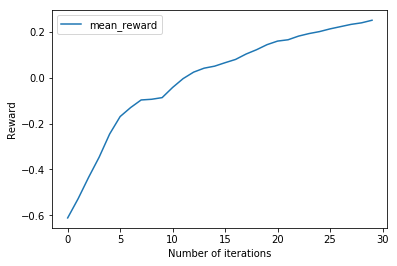

Time 1062.1595323085785
Iteration 29
AverageReturn 0.2502218
StdReturn 0.26171392
MaxReturn 1.1380063
MinReturn -1.2800157
EpLenMean 1.0
EpLenStd 0.0
TimestepsThisBatch 30001
TimestepsSoFar 900030


In [13]:
train_AC(
        exp_name="HalfCheetah-v2",
        env_name="HalfCheetah-v2",
        n_iter=30,
        gamma=0.95,
        min_timesteps_per_batch=30000,
        max_path_length=-1,
        learning_rate=0.02,
        num_target_updates=10,
        num_grad_steps_per_target_update=100,
        animate=True,
        normalize_advantages=False,
        seed=1,
        n_layers=2,
        size=32)

В задаче CartPole-v0 необходимо балансировать маятник двигая тележку, на которой он закреплен, цель добраться до 200 очков. Как видно из графиков, это возможно сделать уже за ~20 итераций. Комбинируя различные значения для num_target_updates, num_grad_steps_per_target_update можно как добиться цели быстрее, так и получать на выходе чаще решенную задачу. 
В InvertedPendulum-v2 столб пытается установить баланс на тележке. Получаем ревард стабильно равный 1. В HalfCheetah-v2 задача научиться бегать за 2 ногое существо, развивать скорость за это получаем награду. С числом итераций награда плавно увеличивалась.